# Делаем свой Portfolio Visualizer

Возможности:

* Получение цен для нескольких активов.
* Ребалансировка по месяцам и годам.
* Графики доходности/просадки.


In [21]:
import talib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
from functools import partial
import time
import requests
import io
import os.path

Необходимо получить бесплатный API-ключ: https://www.alphavantage.co/

In [2]:
AA_API = ''

def download_or_read(symbol):
    """
    Download data or read from local file.
    Save to file without future updating.
    """
    path = 'symbols'
    if not os.path.isdir(path):
        os.mkdir(path)
    
    filename = f'{path}/{symbol}.csv'
    if os.path.isfile(filename):
        with open(filename, 'r') as f:
            return f.read()
    
    url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api}&datatype=csv&outputsize=full'
    while True:
        r = requests.get(url.format(symbol=symbol, api=AA_API))
        content = r.content.decode('UTF-8')
        if 'premium' in content:
            print('Limit error. Waiting for 60 seconds.')
            time.sleep(60)
        else:
            with open(filename, 'w') as f:
                f.write(content) 
            return content

In [3]:
SYMBOLS = ['SPY', 'DIA', 'QQQ', 'IWM', 'AGG', 'TLT', 'BND']

df = None
for s in SYMBOLS:
    data = pd.read_csv(io.StringIO(download_or_read(s)))
    data['symbol'] = s
    if df is None:
        df = data
    else:
        df = pd.concat([df, data])
        
df['dt'] = pd.to_datetime(df['timestamp'])
df = df[['dt', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'adjusted_close']]
print(df.symbol.unique())

['SPY' 'DIA' 'QQQ' 'IWM' 'AGG' 'TLT' 'BND']


In [4]:
def adjusting(df, is_adjusted):
    # adjusting prices with splits & dividends
    if not is_adjusted:
        ratio = df.adjusted_close / df.close
        df['open'] *= ratio
        df['high'] *= ratio
        df['low'] *= ratio
        df['close'] *= ratio
        df['volume'] = (df['volume'] / ratio).astype(int)
    return True
        
is_adjusted = False
print(df['symbol'].unique())

['SPY' 'DIA' 'QQQ' 'IWM' 'AGG' 'TLT' 'BND']


In [5]:
is_adjusted = adjusting(df, is_adjusted)  # adjusting for splits & dividends
print('Adjusted: ', df['symbol'].unique())

Adjusted:  ['SPY' 'DIA' 'QQQ' 'IWM' 'AGG' 'TLT' 'BND']


In [6]:
# show start dates
df.groupby('symbol').dt.min().sort_values()

symbol
SPY   1995-01-03
DIA   1998-01-20
QQQ   1999-03-10
IWM   2000-05-26
TLT   2002-07-26
AGG   2003-09-26
BND   2007-04-10
Name: dt, dtype: datetime64[ns]

# Ставим индексы для группировки по тикерам и периодам

In [7]:
df = df.set_index(['dt', 'symbol'], drop=False).sort_index()
df.tail(len(df.index.levels[1]) * 2)

dt symbol    open      high       low     close  \
dt         symbol                                                           
2018-08-14 AGG    2018-08-14    AGG  106.30  106.3300  106.1600  106.1900   
           BND    2018-08-14    BND   79.21   79.2500   79.1300   79.1400   
           DIA    2018-08-14    DIA  252.76  253.5532  252.2292  253.2100   
           IWM    2018-08-14    IWM  166.91  168.6000  166.8900  168.2000   
           QQQ    2018-08-14    QQQ  181.01  181.6600  180.0400  181.4500   
           SPY    2018-08-14    SPY  282.92  284.1700  282.4833  283.9000   
           TLT    2018-08-14    TLT  120.54  120.5600  120.0300  120.1400   
2018-08-15 AGG    2018-08-15    AGG  106.30  106.3050  106.2500  106.3001   
           BND    2018-08-15    BND   79.21   79.2100   79.2000   79.2100   
           DIA    2018-08-15    DIA  251.84  251.8400  251.8200  251.8400   
           IWM    2018-08-15    IWM  167.64  167.6900  167.5100  167.5500   
           QQQ    2018-08-15    QQQ  180.01  180.1000  180.0100  180.0700   
           SPY    2018-08-15    SPY  282.38  282.3800  282.3600  282.3800   
           TLT    2018-08-15    TLT  120.68  120.7000  120.6500  120.6800   

                     volume  adjusted_close  
dt         symbol                            
2018-08-14 AGG      6087441        106.1900  
           BND      2692659         79.1400  
           DIA      2815934        253.2100  
           IWM     17679762        168.2000  
           QQQ     20867060        181.4500  
           SPY     43818805        283.9000  
           TLT      3851230        120.1400  
2018-08-15 AGG         2764        106.3001  
           BND        35656         79.2100  
           DIA        12341        251.8400  
           IWM       185454        167.5500  
           QQQ       571114        180.0700  
           SPY       570317        282.3800  
           TLT        85556        120.6800

# Группируем и рисуем графики цен

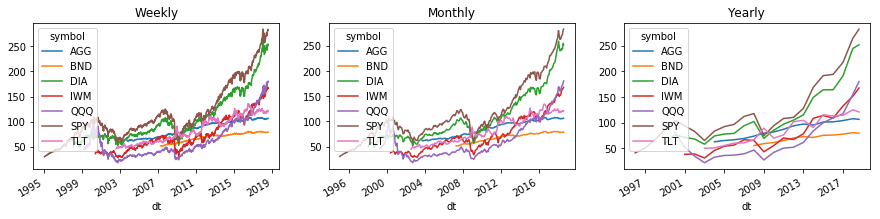

In [8]:
# правила обработки колонок при группировке
agg_rules = {
    'dt': 'last', 'symbol': 'last',
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last',
    'volume': 'sum',
}
fig = plt.figure(figsize=(15, 3), facecolor='white')
level_values = df.index.get_level_values
df.groupby([pd.Grouper(freq='W', level=0)] + [level_values(i) for i in [1]]).agg(
    agg_rules).set_index(['dt', 'symbol'], drop=False).close.unstack(1).plot(ax=fig.add_subplot(131), title="Weekly")
df.groupby([pd.Grouper(freq='M', level=0)] + [level_values(i) for i in [1]]).agg(
    agg_rules).set_index(['dt', 'symbol'], drop=False).close.unstack(1).plot(ax=fig.add_subplot(132), title="Monthly")
df.groupby([pd.Grouper(freq='Y', level=0)] + [level_values(i) for i in [1]]).agg(
    agg_rules).set_index(['dt', 'symbol'], drop=False).close.unstack(1).plot(ax=fig.add_subplot(133), title="Yearly")
plt.show()

# Обновляем индекс исходными датами

In [9]:
monthly = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules)
monthly.tail(len(df.index.levels[1]))

dt symbol     open    high      low     close  \
dt         symbol                                                         
2018-08-31 AGG    2018-08-15    AGG  105.550  106.36  105.512  106.3001   
           BND    2018-08-15    BND   78.750   79.25   78.650   79.2100   
           DIA    2018-08-15    DIA  253.900  256.76  251.030  251.8400   
           IWM    2018-08-15    IWM  165.700  168.71  164.495  167.5500   
           QQQ    2018-08-15    QQQ  176.870  182.63  175.790  180.0700   
           SPY    2018-08-15    SPY  281.560  286.01  279.160  282.3800   
           TLT    2018-08-15    TLT  118.285  121.05  118.070  120.6800   

                      volume  
dt         symbol             
2018-08-31 AGG      34738303  
           BND      25832776  
           DIA      29332719  
           IWM     173440132  
           QQQ     290798506  
           SPY     518842210  
           TLT      66577187

In [10]:
monthly = monthly.set_index(['dt', 'symbol'], drop=False)
monthly.tail(len(df.index.levels[1]))

dt symbol     open    high      low     close  \
dt         symbol                                                         
2018-08-15 AGG    2018-08-15    AGG  105.550  106.36  105.512  106.3001   
           BND    2018-08-15    BND   78.750   79.25   78.650   79.2100   
           DIA    2018-08-15    DIA  253.900  256.76  251.030  251.8400   
           IWM    2018-08-15    IWM  165.700  168.71  164.495  167.5500   
           QQQ    2018-08-15    QQQ  176.870  182.63  175.790  180.0700   
           SPY    2018-08-15    SPY  281.560  286.01  279.160  282.3800   
           TLT    2018-08-15    TLT  118.285  121.05  118.070  120.6800   

                      volume  
dt         symbol             
2018-08-15 AGG      34738303  
           BND      25832776  
           DIA      29332719  
           IWM     173440132  
           QQQ     290798506  
           SPY     518842210  
           TLT      66577187

In [11]:
# monthly.loc[(slice(None), ['QQQ']), :]  # check every symbol

# Изменения за месяц в процентах и старт с 1

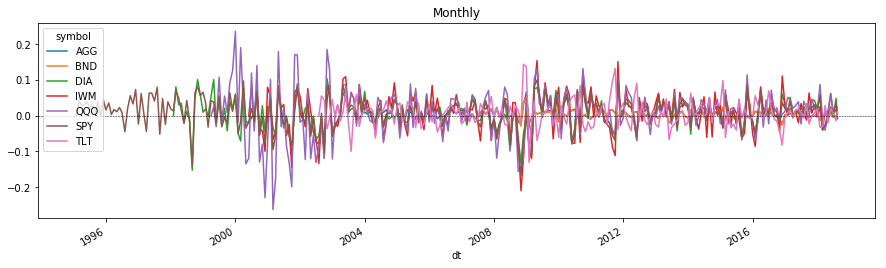

In [12]:
monthly = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules) \
          .set_index(['dt', 'symbol'], drop=False)
# Get monthly changes in percent around 1 and set first items to 1
monthly['pct_close'] = monthly.groupby(level=1)['close'].apply(lambda x: x / x.shift(1) - 1).fillna(0) + 1

# Monthly changes
ax = (monthly.pct_close - 1).unstack(1).plot(title="Monthly", figsize=(15, 4))
ax.axhline(0, color='k', linestyle='--', lw=0.5)
plt.show()

# Сравнение доходности отдельных активов

In [13]:
rolling_prod = lambda x: x.rolling(len(x), min_periods=1).apply(np.prod, raw=True)  # cumulative return
monthly['performance'] = monthly.groupby(level=1)['pct_close'].transform(rolling_prod) - 1
# monthly.loc[(slice(None), ['AGG']), :]  # one symbol's history

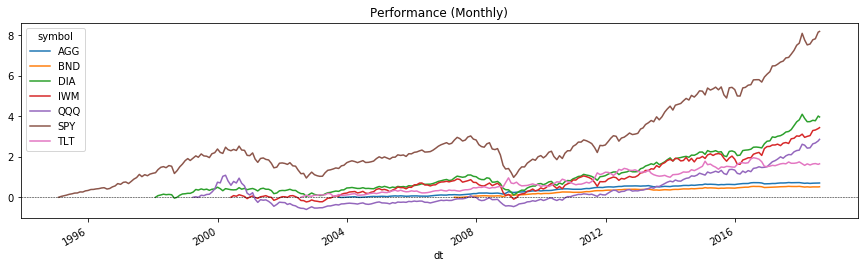

In [14]:
ax = monthly.performance.unstack(1).plot(title="Performance (Monthly)", figsize=(15, 4))
ax.axhline(0, color='k', linestyle='--', lw=0.5)
plt.show()

# Сравнение доходности за период

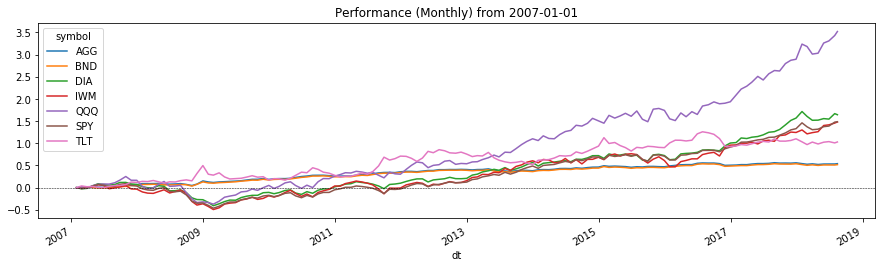

dt symbol     open    high      low     close  \
dt         symbol                                                         
2018-08-15 QQQ    2018-08-15    QQQ  176.870  182.63  175.790  180.0700   
           DIA    2018-08-15    DIA  253.900  256.76  251.030  251.8400   
           SPY    2018-08-15    SPY  281.560  286.01  279.160  282.3800   
           IWM    2018-08-15    IWM  165.700  168.71  164.495  167.5500   
           TLT    2018-08-15    TLT  118.285  121.05  118.070  120.6800   
           AGG    2018-08-15    AGG  105.550  106.36  105.512  106.3001   
           BND    2018-08-15    BND   78.750   79.25   78.650   79.2100   

                      volume  pct_close  performance  
dt         symbol                                     
2018-08-15 QQQ     290798506   1.020516     3.521271  
           DIA      29332719   0.990833     1.644595  
           SPY     518842210   1.003732     1.486611  
           IWM     173440132   1.010128     1.481061  
           TLT      66577187   1.010458     1.029740  
           AGG      34738303   1.004646     0.540775  
           BND      25832776   1.005292     0.518250

In [15]:
rolling_prod = lambda x: x.rolling(len(x), min_periods=1).apply(np.prod, raw=True)  # cumulative return

monthly = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules) \
          .set_index(['dt', 'symbol'], drop=False)
# Get monthly changes in percent around 1 and set first items to 1
monthly['pct_close'] = monthly.groupby(level=1)['close'].apply(lambda x: x / x.shift(1) - 1).fillna(0) + 1

fltr = monthly.dt >= '2007-01-01'
test = monthly[fltr].copy().set_index(['dt', 'symbol'], drop=False)  # update index in new dataframe

test.loc[test.index.levels[0][0], 'pct_close'] = 1  # set start position
test['performance'] = test.groupby(level=1)['pct_close'].transform(rolling_prod) - 1
ax = test.performance.unstack(1).plot(title="Performance (Monthly) from 2007-01-01", figsize=(15, 4))
ax.axhline(0, color='k', linestyle='--', lw=0.5)
plt.show()
test.tail(len(test.index.levels[1])).sort_values('performance', ascending=False)

# Rebalance

### Добавим значения индикаторов на всю историю

In [16]:
# Смещаем данные на 1 день вперед, чтобы не заглядывать в будущее
df['sma50'] = df.groupby(level=1)['close'].transform(lambda x: talib.SMA(x.values, timeperiod=50)).shift(1)
df['sma200'] = df.groupby(level=1)['close'].transform(lambda x: talib.SMA(x.values, timeperiod=200)).shift(1)
df['rsi100'] = df.groupby(level=1)['close'].transform(lambda x: talib.RSI(x.values, timeperiod=100)).shift(1)

In [17]:
# расширим правила группировки
agg_rules_indy = agg_rules.copy()
agg_rules_indy['sma50'] = 'first'
agg_rules_indy['sma200'] = 'first'
agg_rules_indy['rsi100'] = 'first'

# группируем по неделям(W)/месяцам(M)/годам(Y)
grouped = df.groupby([pd.Grouper(freq='M', level=0), level_values(1)]).agg(agg_rules_indy) \
          .set_index(['dt', 'symbol'], drop=False)
grouped['pct_close'] = grouped.groupby(level=1)['close'].apply(lambda x: x / x.shift(1) - 1).fillna(0) + 1
grouped['rebalance_dt'] = grouped.groupby(level=1)['dt'].shift(1) # to exclude future error
grouped.tail(len(grouped.index.levels[1]))

dt symbol     open    high      low     close  \
dt         symbol                                                         
2018-08-15 AGG    2018-08-15    AGG  105.550  106.36  105.512  106.3001   
           BND    2018-08-15    BND   78.750   79.25   78.650   79.2100   
           DIA    2018-08-15    DIA  253.900  256.76  251.030  251.8400   
           IWM    2018-08-15    IWM  165.700  168.71  164.495  167.5500   
           QQQ    2018-08-15    QQQ  176.870  182.63  175.790  180.0700   
           SPY    2018-08-15    SPY  281.560  286.01  279.160  282.3800   
           TLT    2018-08-15    TLT  118.285  121.05  118.070  120.6800   

                      volume       sma50      sma200     rsi100  pct_close  \
dt         symbol                                                            
2018-08-15 AGG      34738303  120.054536  120.387978  49.479635   1.004646   
           BND      25832776  105.651700  106.105286  49.411414   1.005292   
           DIA      29332719   78.748546   79.092231  49.242872   0.990833   
           IWM     173440132  248.208494  243.985535  54.325626   1.010128   
           QQQ     290798506  165.847520  155.681531  54.819285   1.020516   
           SPY     518842210  175.054170  163.810617  55.296142   1.003732   
           TLT      66577187  275.976298  267.722032  55.120815   1.010458   

                  rebalance_dt  
dt         symbol               
2018-08-15 AGG      2018-07-31  
           BND      2018-07-31  
           DIA      2018-07-31  
           IWM      2018-07-31  
           QQQ      2018-07-31  
           SPY      2018-07-31  
           TLT      2018-07-31

### Ребалансируем несколько портфелей

In [18]:
fltr = (grouped.dt >= '2004-01-01') & (grouped.dt < '2020-01-01')
rebalance = grouped[fltr].copy().set_index(['dt', 'symbol'], drop=False)  # update index
rebalance.loc[rebalance.index.levels[0][0], 'pct_close'] = 1  # set start position
rebalance['performance'] = rebalance.groupby(level=1)['pct_close'].transform(rolling_prod) - 1  # reset performance

def rebalance_simple(x):
    # simple rebalance every step
    data = x.unstack(1)
    return (data.pct_close * data['size']).sum() / data['size'].sum()

def rebalance_sma(x):
    # rebalance every step and buy symbols with SMA50 > SMA200
    data = x.unstack(1)
    fltr = data['sma50'] > data['sma200']
    if not data[fltr]['size'].sum():
        return 1  # balance not changed
    return (data[fltr].pct_close * data[fltr]['size']).sum() / data[fltr]['size'].sum()

def rebalance_rsi(x):
    # rebalance every step and buy symbols with RSI100 > 50
    data = x.unstack(1)
    fltr = data['rsi100'] > 50
    if not data[fltr]['size'].sum():
        return 1  # balance not changed
    return (data[fltr].pct_close * data[fltr]['size']).sum() / data[fltr]['size'].sum()

def rebalance_custom(x, df=None):
    # rebalance every step and buy symbols with custom signals
    data = x.unstack(1)
    for s in data.index:
        if data['dt'][s]:
            if data['rebalance_dt'][s] is np.nan:
                continue
            fltr_dt = df['dt'] < data['rebalance_dt'][s]
            values = df[fltr_dt].loc[(slice(None), [s]), 'close'].values
            data.loc[s, 'custom'] = 0
            if len(values) > len(values[np.isnan(values)]):                
                # data.loc[s, 'custom'] = talib.SMA(values, timeperiod=50)[-1] - talib.SMA(values, timeperiod=200)[-1]
                data.loc[s, 'custom'] = talib.RSI(values, timeperiod=100)[-1]
    
    fltr = data['custom'] > 50
    if not data[fltr]['size'].sum():
        return 1  # balance not changed
    return (data[fltr].pct_close * data[fltr]['size']).sum() / data[fltr]['size'].sum()

def drawdown(chg, is_max=False):
    # max drawdowns of returns
    total = len(chg.index)
    rolling_max = chg.rolling(total, min_periods=1).max()
    daily_drawdown = chg/rolling_max - 1.0
    if is_max:
        return daily_drawdown.rolling(total, min_periods=1).min()
    return daily_drawdown

### Portfolios

In [19]:
portfolios = [
    {'symbols': [('SPY', 0.8), ('AGG', 0.2)], 'func': rebalance_sma, 'name': 'Portfolio 80/20 SMA50x200'},
    {'symbols': [('SPY', 0.8), ('AGG', 0.2)], 'func': rebalance_rsi, 'name': 'Portfolio 80/20 RSI100>50'},
    {'symbols': [('SPY', 0.8), ('AGG', 0.2)], 'func': partial(rebalance_custom, df=df), 'name': 'Portfolio 80/20 Custom'},
    {'symbols': [('SPY', 0.8), ('AGG', 0.2)], 'func': rebalance_simple, 'name': 'Portfolio 80/20'},
    {'symbols': [('SPY', 0.4), ('AGG', 0.6)], 'func': rebalance_simple, 'name': 'Portfolio 40/60'},
    {'symbols': [('SPY', 0.2), ('AGG', 0.8)], 'func': rebalance_simple, 'name': 'Portfolio 20/80'},
    {'symbols': [('DIA', 0.2), ('QQQ', 0.3), ('SPY', 0.2), ('IWM', 0.2), ('AGG', 0.1)], 
     'func': rebalance_simple, 'name': 'Portfolio DIA & QQQ & SPY & IWM & AGG'},
    {'symbols': [('SPY', 1)], 'func': rebalance_simple, 'name': 'SPY benchmark'},
]

for p in portfolios:
    # reset rebalance size
    rebalance['size'] = 0.
    for s, pct in p['symbols']:
        rebalance.loc[(slice(None), [s]), 'size'] = pct
    rebalance_perf = rebalance.stack().unstack([1, 2]).apply(p['func'], axis=1, raw=False)
    p['performance'] = (rebalance_perf.rolling(len(rebalance_perf), min_periods=1).apply(np.prod, raw=True) - 1)
    p['drawdown'] = drawdown(p['performance'] + 1, is_max=True)
    
print("Total: ", len(portfolios))

Total:  8


# Графики портфелей

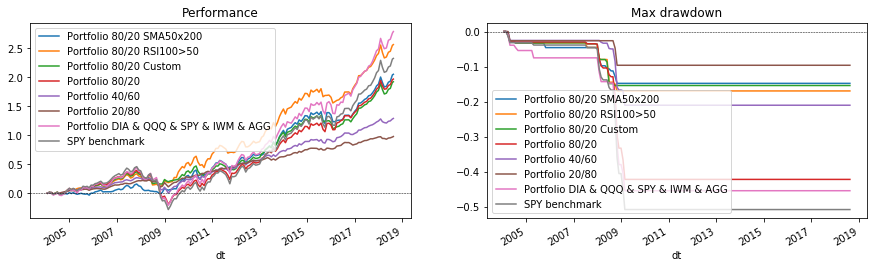

,performance,drawdown
Portfolio DIA & QQQ & SPY & IWM & AGG,279.190828,-45.425214
Portfolio 80/20 RSI100>50,256.589654,-16.954700
SPY benchmark,232.739842,-50.798408
Portfolio 80/20 SMA50x200,205.328912,-14.791942
Portfolio 80/20,197.109926,-42.196485
Portfolio 80/20 Custom,192.420563,-15.407258
Portfolio 40/60,129.090960,-21.031810
Portfolio 20/80,97.863735,-9.629876


In [20]:
results = pd.DataFrame([])
fig = plt.figure(figsize=(15, 4), facecolor='white')

ax_perf = fig.add_subplot(121)
ax_dd = fig.add_subplot(122)
for p in portfolios:
    p['performance'].rename(p['name']).plot(ax=ax_perf, legend=True, title='Performance')
    p['drawdown'].rename(p['name']).plot(ax=ax_dd, legend=True, title='Max drawdown')
    
    results.loc[p['name'], 'performance'] = p['performance'][-1] * 100
    results.loc[p['name'], 'drawdown'] = p['drawdown'][-1] * 100

ax_perf.axhline(0, color='k', linestyle='--', lw=0.5)
ax_dd.axhline(0, color='k', linestyle='--', lw=0.5)

plt.show()
results.sort_values('performance', ascending=False)

# Testing